# How to use OpenCV to segment the cells

## Package inclusion for Python

In [1]:
%matplotlib inline

import copy
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Read the image from a file on the disk and return a new matrix

In [2]:
colour_image = cv2.imread("../NewCamera_171121_DSC00867.jpg", cv2.IMREAD_COLOR)

## Check for errors

In [3]:
# Check for failure
if colour_image is None: 
    raise Exception("Could not open or find the image")

## Convert to greyscale

In [4]:
grey_image = cv2.cvtColor(colour_image, cv2.COLOR_RGB2GRAY)

## Display the image

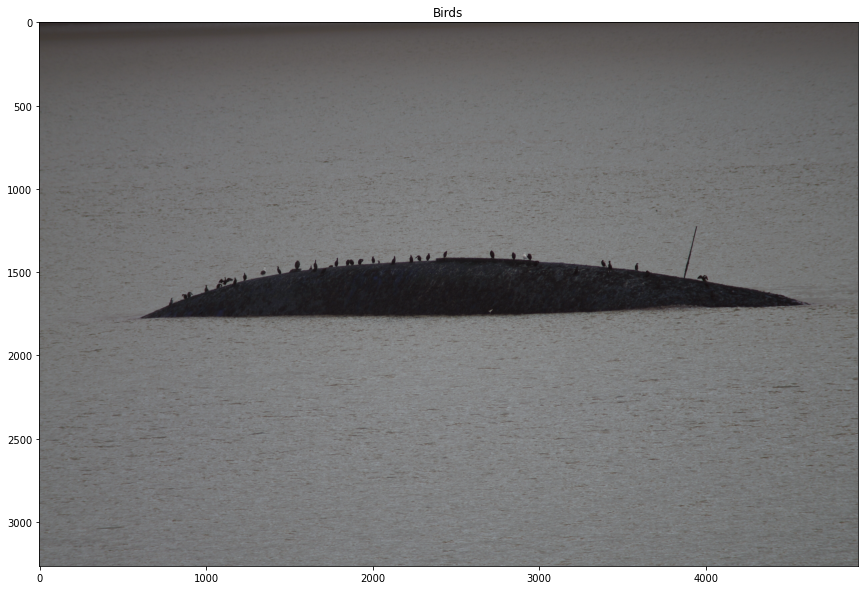

In [5]:
plt.figure(figsize=(20, 10))
plt.imshow(colour_image, cmap="gray")
plt.title('Birds')
plt.show()

## Compute its histogram

In [6]:
histogram_size = 256

histogram = cv2.calcHist([grey_image], # Image to analyse
                         [0], # Number of channels
                         None, # Mask
                         [histogram_size], # Number of bins
                         [0, 255]) # Ranges

## Plot the histogram

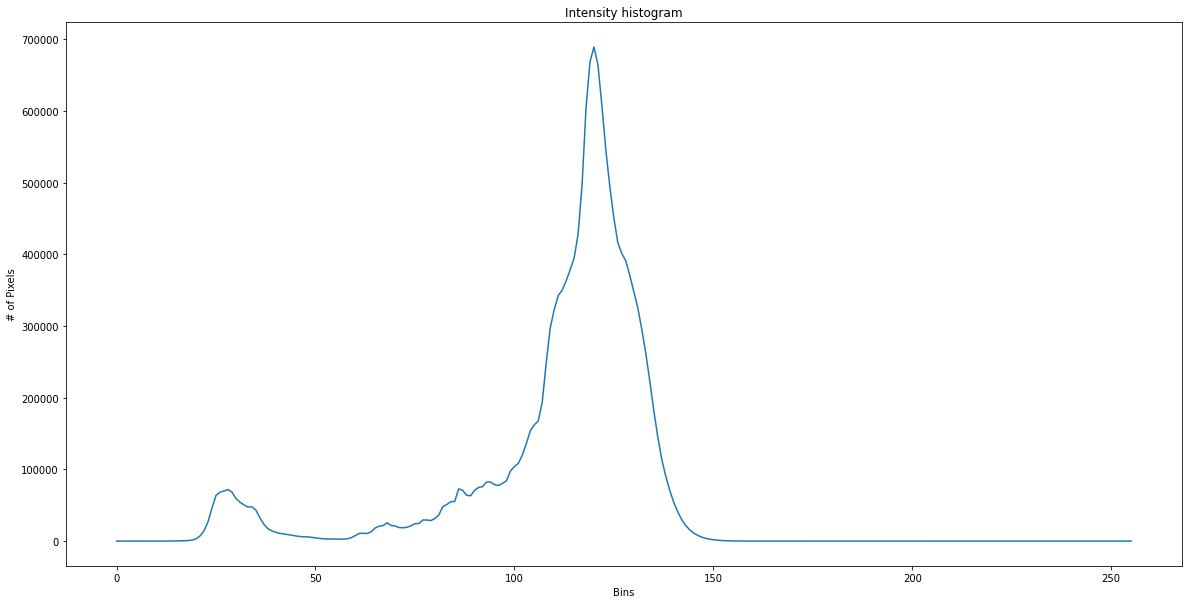

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(histogram)
plt.title('Intensity histogram')
# plt.yscale('log')
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.show()

## Binary threshold

A lot of information about the various thresholds technique in OpenCV is available at [https://docs.opencv.org/master/db/d8e/tutorial_threshold.html](https://docs.opencv.org/master/db/d8e/tutorial_threshold.html) on OpenCV's website. We want the background in black, and the cells in white. We use the inverse of the binary threshold then. See `THRESH_BINARY_INV` in [https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576](https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576).

In [8]:
segmented = None

def callback(value: int):
    global grey_image
    global threshold_value
    global segmented
    
    threshold_value = value
    
    segmented = cv2.threshold(grey_image,
          threshold_value,
          255,
          cv2.THRESH_BINARY_INV)[1]
    
    cv2.imshow("Segmentation", segmented) # Show our image inside the created window.

In [9]:
threshold_value = 65 # Taken from the histogram

cv2.namedWindow("Segmentation", cv2.WINDOW_GUI_EXPANDED) # Create a window
cv2.createTrackbar("Threshold: ", "Segmentation", threshold_value, 255, callback)

callback(threshold_value)

[ WARN:0] global /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-vy_omupv/opencv/modules/highgui/src/window.cpp (704) createTrackbar UI/Trackbar(Threshold: @Segmentation): Using 'value' pointer is unsafe and deprecated. Use NULL as value pointer. To fetch trackbar value setup callback.


## Display the result

In [10]:
key = -1
background = None

while key != 27 and key != 'q':

    key = cv2.waitKey(0) # Wait for any keystroke in the window
    
cv2.destroyAllWindows() # Destroy all the created windows

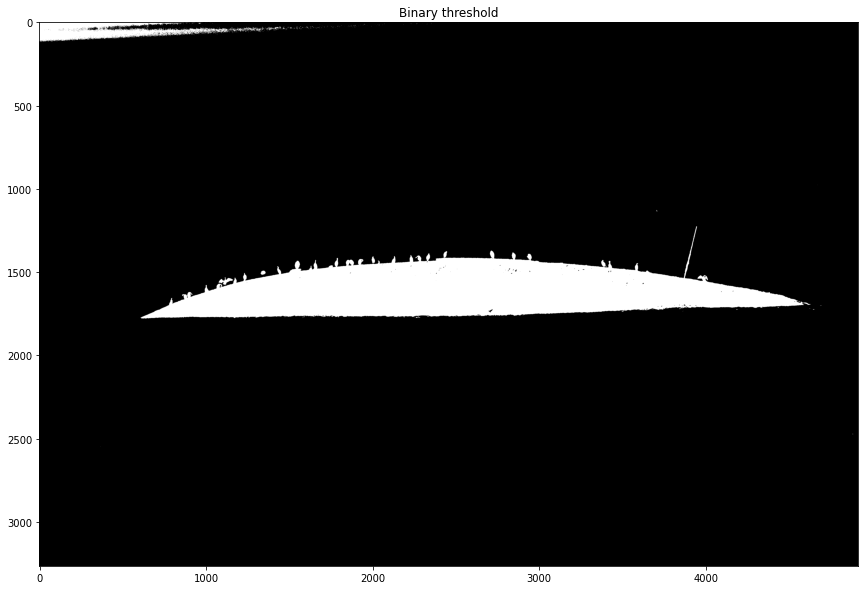

In [11]:
plt.figure(figsize=(20, 10))
plt.imshow(segmented.astype(np.uint8), cmap="gray")
plt.title('Binary threshold')
plt.show()

## Cleaning

In [12]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                    (10, 10), 
                                    (2, 2))

island_and_birds_mask = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, element);
island_and_birds_mask = cv2.morphologyEx(island_and_birds_mask, cv2.MORPH_OPEN, element);

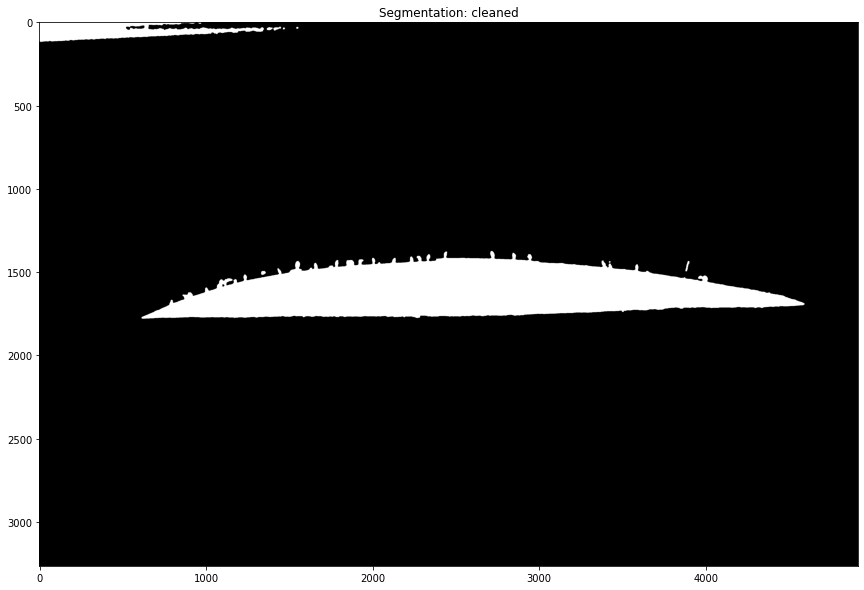

In [13]:
plt.figure(figsize=(20, 10))
plt.imshow(island_and_birds_mask, cmap="gray")
plt.title('Segmentation: cleaned')
plt.show()

In [14]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                    (30, 30), 
                                    (2, 2))

island_mask = cv2.morphologyEx(segmented, cv2.MORPH_OPEN, element);
island_mask = cv2.morphologyEx(island_mask, cv2.MORPH_CLOSE, element);


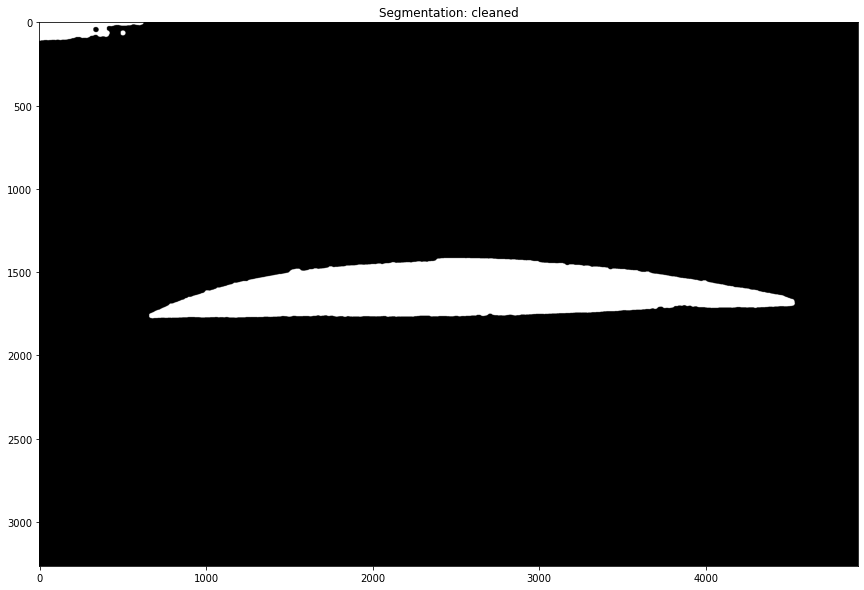

In [15]:
plt.figure(figsize=(20, 10))
plt.imshow(island_mask, cmap="gray")
plt.title('Segmentation: cleaned')
plt.show()

In [16]:
bird_mask = island_and_birds_mask - island_mask

element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                    (5, 5), 
                                    (2, 2))

bird_mask = cv2.erode(bird_mask, element, iterations = 3)

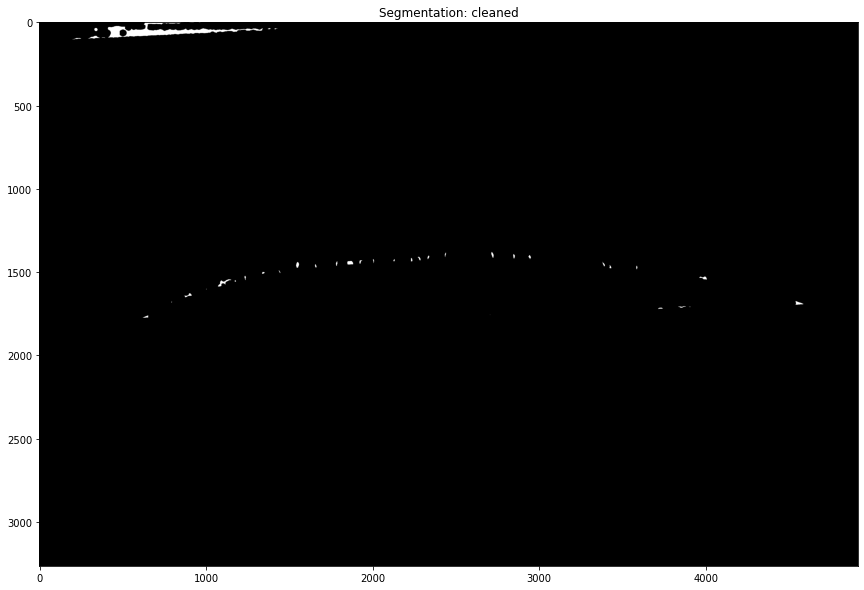

In [17]:
plt.figure(figsize=(20, 10))
plt.imshow(bird_mask, cmap="gray")
plt.title('Segmentation: cleaned')
plt.show()

## Find the birds

In [18]:
contours, hierarchy = cv2.findContours(bird_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

min_x = colour_image.shape[1]
max_x = 0

for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    
    if y > 150:
        min_x = min(min_x, x)
        max_x = max(max_x, x)

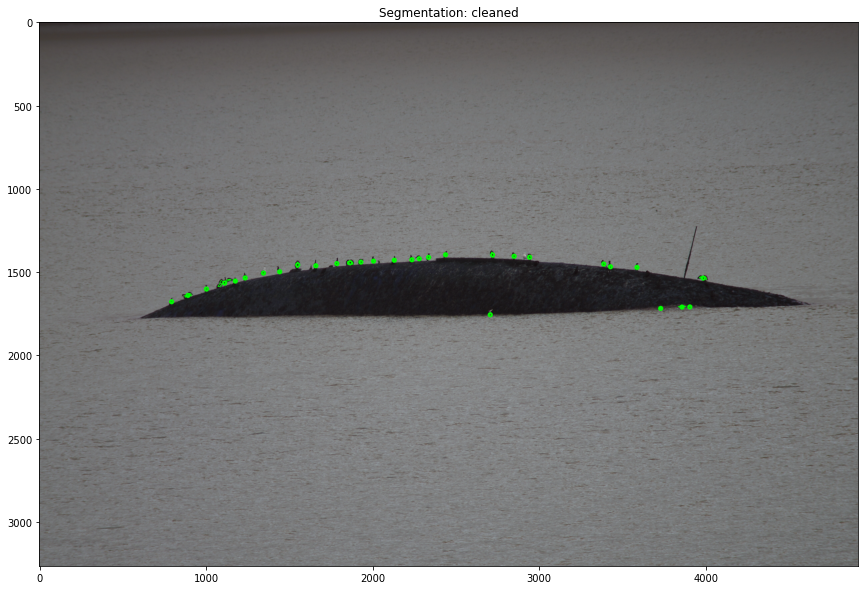

In [19]:
image_contour = copy.deepcopy(colour_image)

for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if y > 150:
        if x != min_x and x != max_x:
            cv2.drawContours(image_contour, [cnt], 0, (0,255,0), 3)
            # cv2.rectangle(image_contour, (x,y), (x+w, y+h), (0,255,0), 10)
            image_contour = cv2.circle(image_contour, (round(x+w/2),round(y+h/2)), 10, (0,255,0), 10)
        # else:
        #     cv2.drawContours(image_contour, [cnt], 0, (255, 0,0), 3)
        #     # cv2.rectangle(image_contour, (x,y), (x+w, y+h), (255,0,0),5)
    
plt.figure(figsize=(20, 10))
plt.imshow(image_contour)
plt.title('Segmentation: cleaned')
plt.show()

In [20]:
# cv2.destroyAllWindows() # Destroy all the created windows